# Bring Your Own COG
Sentinel Hub allows you to access your own data stored in your S3 bucket with the powerful Sentinel Hub API. Since data remains on your bucket, you keep full control over it. This functionality requires no replication of data and allows you to exercise the full power of the Sentinel Hub service including Custom algorithms. [More information here!](https://www.sentinel-hub.com/bring-your-own-data/)

The [Sentinel Hub Dashboard](https://apps.sentinel-hub.com/dashboard/) has a very user-friendly "Bring your own COG" tab. If you are not going to be creating collections, adding/updating collection tiles, etc. daily, the Dashboard tool is your friend. For the rest, this tutorial is a simple walk-through on creating, updating, listing, and deleting your BYOC collections through Python using `sentinelhub-py`.

Some general and BYOC related functionality imports:

In [1]:
# Configure plots for inline use in Jupyter Notebook
%matplotlib inline

import datetime as dt

# Utilities
import boto3
import dateutil
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Sentinel Hub
from sentinelhub import (
    CRS,
    BBox,
    ByocCollection,
    ByocCollectionAdditionalData,
    ByocCollectionBand,
    ByocTile,
    DataCollection,
    DownloadFailedException,
    MimeType,
    SentinelHubBYOC,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
)

/Users/chung-xianghong/Desktop/SH-VAS/git/sentinelhub-py/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prerequisites
BYOC API requires Sentinel Hub account. Please see [configuration instructions](https://sentinelhub-py.readthedocs.io/en/latest/configure.html) how to set up your configuration.

In [2]:
# Insert your credentials here in case you don't already have them in config.json file:
SH_CLIENT_ID = ""
SH_CLIENT_SECRET = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

config = SHConfig()

if SH_CLIENT_ID and SH_CLIENT_SECRET:
    config.sh_client_id = SH_CLIENT_ID
    config.sh_client_secret = SH_CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Sentinel Hub BYOC API, please provide the credentials (client ID and client secret).")

if AWS_ACCESS_KEY_ID and AWS_SECRET_ACCESS_KEY:
    config.aws_access_key_id = AWS_ACCESS_KEY_ID
    config.aws_secret_access_key = AWS_SECRET_ACCESS_KEY

## BYOC collections
`SentinelHubBYOC` class holds the methods for interacting with Sentinel Hub services. Let’s initialize it with our `config`:

In [3]:
# Initialize SentinelHubBYOC class
byoc = SentinelHubBYOC(config=config)

### Create new collection
The easiest way to create a collection is to use its dataclass:

In [4]:
new_collection = ByocCollection(name="new collection", s3_bucket="my-s3-bucket")

The `new collection` is accessible on `my-s3-bucket` s3 bucket (please see how to configure your bucket for Sentinel Hub service [here](https://docs.sentinel-hub.com/api/latest/data/byoc/#aws-bucket-settings)).

The call to create the collection on Sentinel Hub, will return newly created collection, which will get its own collection id:

In [5]:
created_collection = byoc.create_collection(new_collection)

In [6]:
print("name:", created_collection["name"])
print("id:", created_collection["id"])

name: new collection
id: 55de1efa-64ec-457b-8f52-a54033d6093c


### Get a list of your collections
Now we have created a data collection named `new collection`, we can retrieve it with the following code.

In [7]:
my_collection = byoc.get_collection(created_collection["id"])

Let's have a look at the the collection we just created.

In [8]:
print(f"name: {my_collection['name']}")
print(f"id: {my_collection['id']}")

name: new collection
id: 55de1efa-64ec-457b-8f52-a54033d6093c


In cases where you have a large amount of collections and you would only like to load collection info for a few collections, the following code would be a good option for you:

In [9]:
collections_iterator = byoc.iter_collections()

In [10]:
my_collection_using_next = next(collections_iterator)
print("name:", my_collection_using_next["name"])
print("id:", my_collection_using_next["id"])

name: new collection
id: 55de1efa-64ec-457b-8f52-a54033d6093c


**Note:** `collections_iterator` won't necessarily return collections in the same order they were created. If you already have collections, the output above could show a collection other than the one we just created.

If you prefer to work with dataclasses, you can also run the following code:

```python
my_collection = ByocCollection.from_dict(next(collections_iterator))
```

One can of course retrieve all of them in one go like so:

In [11]:
my_collections = list(collections_iterator)

for collection in my_collections:
    print((collection["name"], collection["id"]))

('new collection', '55de1efa-64ec-457b-8f52-a54033d6093c')


A useful way for managing your collections is `pandas.DataFrame` you can create like so:

In [12]:
my_collections_df = pd.DataFrame(data=list(byoc.iter_collections()))
my_collections_df[["id", "name", "created"]].head()

,id,name,created
0,55de1efa-64ec-457b-8f52-a54033d6093c,new collection,2023-01-13T11:14:52.955477Z


### Update existing collection

Anything you can do on Dashboard, Bring your own COG tab, you can do programmatically as well. Below we're going to rename the `new collection` collection to `renamed new collection`:

In [13]:
my_collection["name"] = "renamed new collection"

When using `next()`, run the following code:

```python
my_collection['name'] = 'renamed new collection'
```

When using dataclass, run the following code:
```python
my_collection.name = 'renamed new collection'
```

When using `list`, run the following code:
```python
collection_to_be_updated = [
    collection for collection in my_collections 
    if collection['id'] == my_collection['id']
][0]
collection_to_be_updated['name'] = 'renamed new collection'
```

**Note:** While you can change other fields as well, `s3_bucket` cannot be changed, and the `bitDepth` of bands in the collection is something that is pertinent to the COGs themselves and populated during the ingestion.

To update the collection, call:

In [14]:
byoc.update_collection(my_collection)

''

Now we can see that the `new collection` collection has been renamed as `renamed new collection`.

In [15]:
get_renamed_collection = byoc.get_collection(created_collection["id"])
print("name:", get_renamed_collection["name"])
print("id:", get_renamed_collection["id"])

name: renamed new collection
id: 55de1efa-64ec-457b-8f52-a54033d6093c


### Delete collection

If you are the owner of the collection, you can also delete it. 

<div class="alert alert-warning">

<b>Warning:</b>
    
Beware! Deleting the collection will also delete all its tiles!
</div>

In [16]:
byoc.delete_collection(my_collection)

''

The collection can also be deleted via passing its id to `byoc.delete_collection()` as shown below:
```python
byoc.delete_collection(my_collection['id'])
```

Trying to access this collection now will fail.

In [17]:
try:
    deleted_collection = byoc.get_collection(my_collection["id"])
except DownloadFailedException as e:
    print(e)

Failed to download from:
https://services.sentinel-hub.com/api/v1/byoc/collections/55de1efa-64ec-457b-8f52-a54033d6093c
with HTTPError:
404 Client Error: Not Found for url: https://services.sentinel-hub.com/api/v1/byoc/collections/55de1efa-64ec-457b-8f52-a54033d6093c
Server response: "{"status": 404, "reason": "Not Found", "message": "Collection 55de1efa-64ec-457b-8f52-a54033d6093c not found.", "code": "COMMON_NOT_FOUND"}"


## BYOC tiles (cogs in the collection)

Your data needs to be organized into collections of tiles. Each tile needs to contain a set of bands and (optionally) an acquisition date and time. Tiles with the same bands can be grouped into collections. Think of the Sentinel-2 data source as a collection of Sentinel-2 tiles.

Tiles have to be on an s3 bucket and need to be in COG format. We will not go into details about the COGification process; users can have a look at the [documentation](https://docs.sentinel-hub.com/api/latest/data/byoc/#converting-to-cog) or use the [BYOC tool](https://docs.sentinel-hub.com/api/latest/data/byoc/#sentinel-hub-byoc-tool) that will take care of creating a collection and ingesting the tiles for you.

### Creating a new tile (and ingesting it to collection)

When we create a new tile and add it to the collection, the ingestion process on the Sentinel Hub side will happen, checking if the tile corresponds to the COG specifications as well as if it conforms to the collection.

The simplest way to create a new tile is by using the `ByocTile` dataclass, which will complain if the required fields are missing. 

In [18]:
new_tile = ByocTile(path="2019/11/27/28V/(BAND).tif", sensing_time=dt.datetime(2019, 11, 27))

**Note:**

- The most important field of the tile is its `path` on an s3 bucket. For example, if your band files are stored in `s3://bucket-name/folder/`, then set `folder` as the tile path. In this case, the band names will equal the file names. For example, the band B1 corresponds to the file `s3://bucket-name/folder/B1.tiff`. If your file names have something other than just the band name, such as a prefix, this is fine as long as the prefix is the same for all files. In this case, the path needs to include this prefix and also the band placeholder: `(BAND)`. Adding the extension is optional. For example, this is what would happen if you would use the following path `folder/tile_1_(BAND)_2019.tiff` for the following files:
  - `s3://bucket-name/folder/tile_1_B1_2019.tiff` - the file would be used, the band name would be B1
  - `s3://bucket-name/folder/tile_1_B2_2019.tiff` - the file would be used, the band name would be B2
  - `s3://bucket-name/folder/tile_2_B1_2019.tiff` - the file would not be used
  - `s3://bucket-name/folder/tile_2_B2_2019.tiff` - the file would not be used
- `ByocTile` takes `sensing_time` as optional parameters, but setting the `sensing_time` is highly recommended since it makes the collection “temporal” and help you search for the data with Sentinel Hub services. 
- `tile_geometry` is optional as it is the bounding box of the tile and will be read from COG file. 
- `cover_geometry` is the geometry of where the data (within the bounding box) is and can be useful for optimized search as an optional parameter. For a good explanation of the `coverGeometry` please see [docs](https://docs.sentinel-hub.com/api/latest/data/byoc/#a-note-about-cover-geometries). 

Let's [create a new collection](#Create-new-collection) for these tiles.

In [19]:
new_collection = ByocCollection(name="byoc-s2l2a-120m-mosaic", s3_bucket="sentinel-s2-l2a-mosaic-120")
created_collection = byoc.create_collection(new_collection)

In [20]:
created_tile = byoc.create_tile(created_collection, new_tile)

The response from `byoc.create_tile` has a valid `id`, and its `status` is set to `WAITING`. Checking the tile `status` after a while (by [requesting this tile](#Get-tiles-from-your-collection)) will tell you if it has been `INGESTED` or if the ingestion procedure `FAILED`. In case of failure, additional information (with the cause of failure) will be available in the tile `additional_data`.

In [21]:
created_tile

{'id': 'c48a8efb-6efb-4edb-bf18-6d7de898557f',
 'created': '2023-01-13T11:15:09.623453Z',
 'ingestionStart': '2023-01-13T11:15:09.623453Z',
 'sensingTime': '2019-11-27T00:00:00Z',
 'path': '2019/11/27/28V/(BAND).tif',
 'status': 'WAITING'}

### Add multiple tiles to a single collection
A data collection can for sure contain multiple tiles. It is important to know that adding multiple tiles will work only if these tiles have the same bands. Let's add more tiles from the [Sentinel-2 L2A 120m Mosaic](https://registry.opendata.aws/sentinel-s2-l2a-mosaic-120/) listed on the open data registry on AWS to the collection.

We first define a function to get a list of paths for each tile:

In [22]:
def list_objects_path(bucket, year_count, month_count, day_count, config):
    tiles_path = []
    client = boto3.client(
        "s3", aws_access_key_id=config.aws_access_key_id, aws_secret_access_key=config.aws_secret_access_key
    )
    result = client.list_objects(Bucket=bucket, Delimiter="/")
    for year in result.get("CommonPrefixes")[:year_count]:
        year_result = client.list_objects(Bucket=bucket, Delimiter="/", Prefix=year.get("Prefix"))
        for month in year_result.get("CommonPrefixes")[:month_count]:
            month_result = client.list_objects(Bucket=bucket, Delimiter="/", Prefix=month.get("Prefix"))
            for day in month_result.get("CommonPrefixes")[:day_count]:
                day_result = client.list_objects(Bucket=bucket, Delimiter="/", Prefix=day.get("Prefix"))
                for tile in day_result.get("CommonPrefixes"):
                    tiles_path.append(tile.get("Prefix"))
    return tiles_path

Next we obtain a list of paths for tiles available on `s3://sentinel-s2-l2a-mosaic-120/2019/1/1/`.

In [23]:
tiles_path = list_objects_path(
    bucket="sentinel-s2-l2a-mosaic-120", year_count=1, month_count=1, day_count=1, config=config
)

Then we can add tiles to the collection with a `for` loop.

In [24]:
for tile in tiles_path:
    year, month, day = tile.split("/")[:3]
    byoc_tile = ByocTile(path=f"{tile}(BAND).tif", sensing_time=dt.datetime(int(year), int(month), int(day)))
    byoc.create_tile(created_collection, byoc_tile)

**Note:** The tile ingesting process could take some time, please wait a few more minutes after the cell has done running before heading to the next step.

### Get tiles from your collection
After `byoc.create_tile` being executed, we can request the tile from the collection where it is ingested. To request a specific tile you can pass a collection id and a tile id to the `get_tile` method.

In [25]:
tile = byoc.get_tile(collection=created_collection["id"], tile=created_tile["id"])

In [26]:
tile

{'id': 'c48a8efb-6efb-4edb-bf18-6d7de898557f',
 'created': '2023-01-13T11:15:09.623453Z',
 'ingestionStart': '2023-01-13T11:15:09.623453Z',
 'sensingTime': '2019-11-27T00:00:00Z',
 'coverGeometry': {'type': 'Polygon',
  'crs': {'type': 'name',
   'properties': {'name': 'urn:ogc:def:crs:EPSG::32628'}},
  'coordinates': [[[299999.9980359557, 6899880.000729979],
    [600120.0000155062, 6899880.00067825],
    [600120.0000231846, 7100040.000720726],
    [299999.9970628682, 7100040.000814738],
    [299999.9980359557, 6899880.000729979]]]},
 'tileGeometry': {'type': 'Polygon',
  'crs': {'type': 'name',
   'properties': {'name': 'urn:ogc:def:crs:EPSG::32628'}},
  'coordinates': [[[300000.0, 7100040.0],
    [600120.0, 7100040.0],
    [600120.0, 6899880.0],
    [300000.0, 6899880.0],
    [300000.0, 7100040.0]]]},
 'path': '2019/11/27/28V/(BAND).tif',
 'status': 'INGESTED',
 'additionalData': {'hasAddedPoints': True,
  'filesMetadata': {'B02': {'headerSize': 1328,
    'etag': '"838a04acfa29e10b3b

You can of course retrieve all tiles into a list.

In [27]:
tiles = list(byoc.iter_tiles(created_collection))

In cases where you have a large collection with a lot of tiles and you would only like to load tile info for a few tiles, the following code using `next()` would be a good option for you:
```python
tile = next(byoc.iter_tiles(created_collection))
```

To convert it to ByocTile dataclass using the code below:
```python
tile = ByocTile.from_dict(next(byoc.iter_tiles(created_collection)))
```

Let's take a look at the keys of the first dictionary, which contains the info of the first tile, in the returned list.

In [28]:
list(tiles[0].keys())

['id',
 'created',
 'ingestionStart',
 'sensingTime',
 'coverGeometry',
 'tileGeometry',
 'path',
 'status',
 'additionalData']

To check if there's any tile failed to be ingested, run the code below:

In [29]:
tiles_failed_to_be_ingested = [tile["path"] for tile in tiles if tile["status"] == "FAILED"]
tiles_failed_to_be_ingested

[]

### Visualize the tiles in your collection
Using `ByocTile` dataclass, which will properly parse tile geometries, date-time strings, etc., one can create a `geopandas.GeoDataFrame`.

**Note:** the geometries can be in different coordinate reference systems, so a transform to a common CRS might be needed.

In [30]:
tile_iterator = byoc.iter_tiles(created_collection)

In [31]:
tiles_for_visualized = []
for i in range(100):
    tiles_for_visualized.append(ByocTile.from_dict(next(tile_iterator)))

tiles_gdf = gpd.GeoDataFrame(
    tiles_for_visualized,
    geometry=[t.cover_geometry.transform(CRS.WGS84).geometry for t in tiles_for_visualized],
    crs="epsg:4326",
)

In [32]:
tiles_gdf.head()

,path,status,tile_id,tile_geometry,cover_geometry,created,sensing_time,additional_data,other_data,geometry
0,2019/1/1/48W/(BAND).tif,INGESTED,0050b174-4e94-406e-b7cc-589d596f741d,"Geometry(POLYGON ((399960 8000040, 700080 8000...",Geometry(POLYGON ((399959.9999769499 7099920.0...,2023-01-13 11:27:26.525596+00:00,2019-01-01 00:00:00+00:00,"{'hasAddedPoints': True, 'filesMetadata': {'B0...",{'ingestionStart': '2023-01-13T11:27:26.525596Z'},"POLYGON ((102.95358 64.01166, 109.08813 63.968..."
1,2019/1/1/28N/(BAND).tif,INGESTED,006289e1-db55-45d2-afaa-27ae518e58c4,"Geometry(POLYGON ((600000 900000, 900120 90000...",Geometry(POLYGON ((599999.9999999745 599879.99...,2023-01-13 11:26:34.375675+00:00,2019-01-01 00:00:00+00:00,"{'hasAddedPoints': True, 'filesMetadata': {'B0...",{'ingestionStart': '2023-01-13T11:26:34.375675Z'},"POLYGON ((-14.09734 5.42647, -11.39057 5.41637..."
2,2019/1/1/53U/(BAND).tif,INGESTED,00ba1aa8-2e9e-451b-9320-1b3386603d92,"Geometry(POLYGON ((300000 6200040, 800040 6200...",Geometry(POLYGON ((299999.9998340545 5299920.0...,2023-01-13 11:27:43.252295+00:00,2019-01-01 00:00:00+00:00,"{'hasAddedPoints': True, 'filesMetadata': {'B0...",{'ingestionStart': '2023-01-13T11:27:43.252295Z'},"POLYGON ((132.32798 47.82152, 139.00575 47.782..."
3,2019/1/1/51S/(BAND).tif,INGESTED,00d98ce7-3d39-48c8-8511-44e2f3a2aee9,"Geometry(POLYGON ((199980 4400040, 800100 4400...",Geometry(POLYGON ((199979.99958487228 3499919....,2023-01-13 11:27:36.544894+00:00,2019-01-01 00:00:00+00:00,"{'hasAddedPoints': True, 'filesMetadata': {'B0...",{'ingestionStart': '2023-01-13T11:27:36.544894Z'},"POLYGON ((119.83822 31.59531, 126.16262 31.595..."
4,2019/1/1/19H/(BAND).tif,INGESTED,0138f39d-3106-4b2f-8065-c0103b57c271,"Geometry(POLYGON ((199980 6500020, 800100 6500...",Geometry(POLYGON ((199979.99898124964 5599899....,2023-01-13 11:26:16.454520+00:00,2019-01-01 00:00:00+00:00,"{'hasAddedPoints': True, 'filesMetadata': {'B0...",{'ingestionStart': '2023-01-13T11:26:16.454520Z'},"POLYGON ((-72.49900 -39.69805, -65.50006 -39.6..."


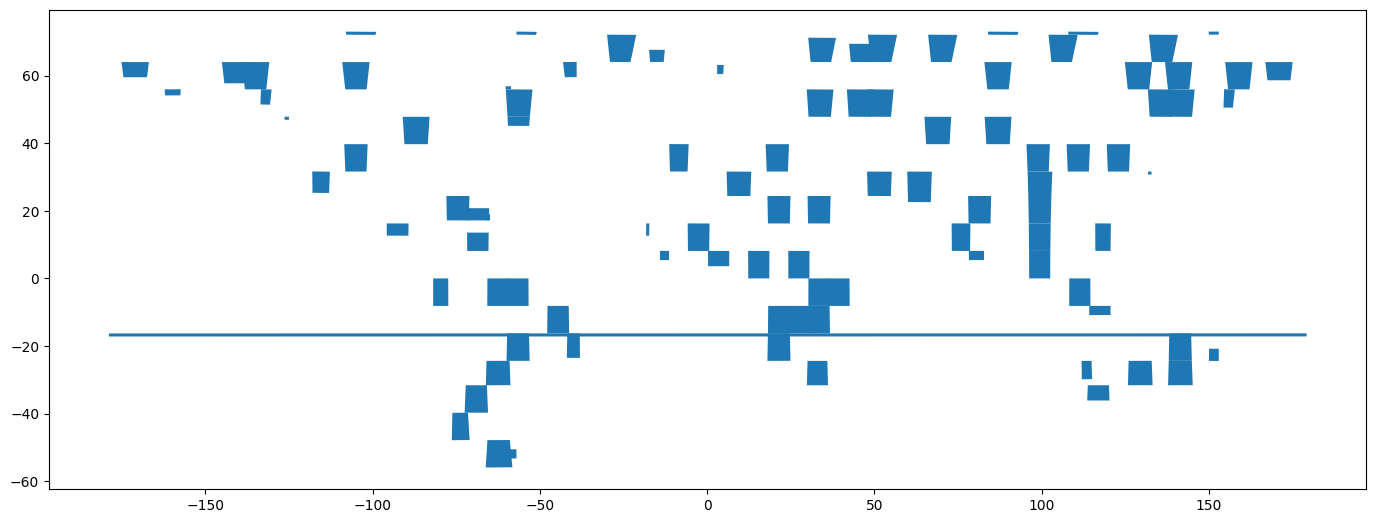

In [33]:
fig, ax = plt.subplots(figsize=(17, 8))
tiles_gdf.plot(ax=ax);

In the above example, the ingested tiles are 100 tiles from the [Sentinel-2 L2A 120m Mosaic](https://registry.opendata.aws/sentinel-s2-l2a-mosaic-120/) which contains 19869 tiles around the globe, hence the tiles are so sparse in the image above.

### Updating and deleting a tile

Updating and deleting a tile follow the same logic as updating/deleting a collection.

- To update a tile:

In [34]:
tile["sensingTime"] = "2021-06-29T18:02:34"
byoc.update_tile(created_collection, tile)

''

After updating we can see that the `sensingTime` has been changed.

In [35]:
byoc.get_tile(collection=created_collection["id"], tile=created_tile["id"])["sensingTime"]

'2021-06-29T18:02:34Z'

- To delete a tile:

In [36]:
byoc.delete_tile(created_collection, tile)

''

Now the tile is gone forever.

In [37]:
tiles = list(byoc.iter_tiles(created_collection))
[tile for tile in tiles if tile["id"] == created_tile["id"]]

[]

## Retrieve data from collection
Once we have a collection created and its tiles ingested, we can retrieve the data from said collection.
We will be using ProcessAPI for this.

In [38]:
data_collection = DataCollection.define_byoc(created_collection["id"])

Alternatively using dataclass:
```python
data_collection = my_collection_dataclass.to_data_collection()
```

In [39]:
tile_time = dateutil.parser.parse(tiles[0]["sensingTime"])

If using dataclass run:
```python
tile_time = tile_dataclass.sensing_time
```

Below we're going to request a false color image of Caspian Sea.

In [40]:
caspian_sea_bbox = BBox([49.9604, 44.7176, 51.0481, 45.2324], crs=CRS.WGS84)

In [41]:
false_color_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B08","B04","B03", "dataMask"],
    output: { bands: 4 },
  };
}

var f = 2.5/10000;
function evaluatePixel(sample) {
  return [f*sample.B08, f*sample.B04, f*sample.B03, sample.dataMask];
}
"""

request = SentinelHubRequest(
    evalscript=false_color_evalscript,
    input_data=[SentinelHubRequest.input_data(data_collection=data_collection, time_interval=tile_time)],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=caspian_sea_bbox,
    size=bbox_to_dimensions(caspian_sea_bbox, 100),
    config=config,
)

In [42]:
data = request.get_data()[0]

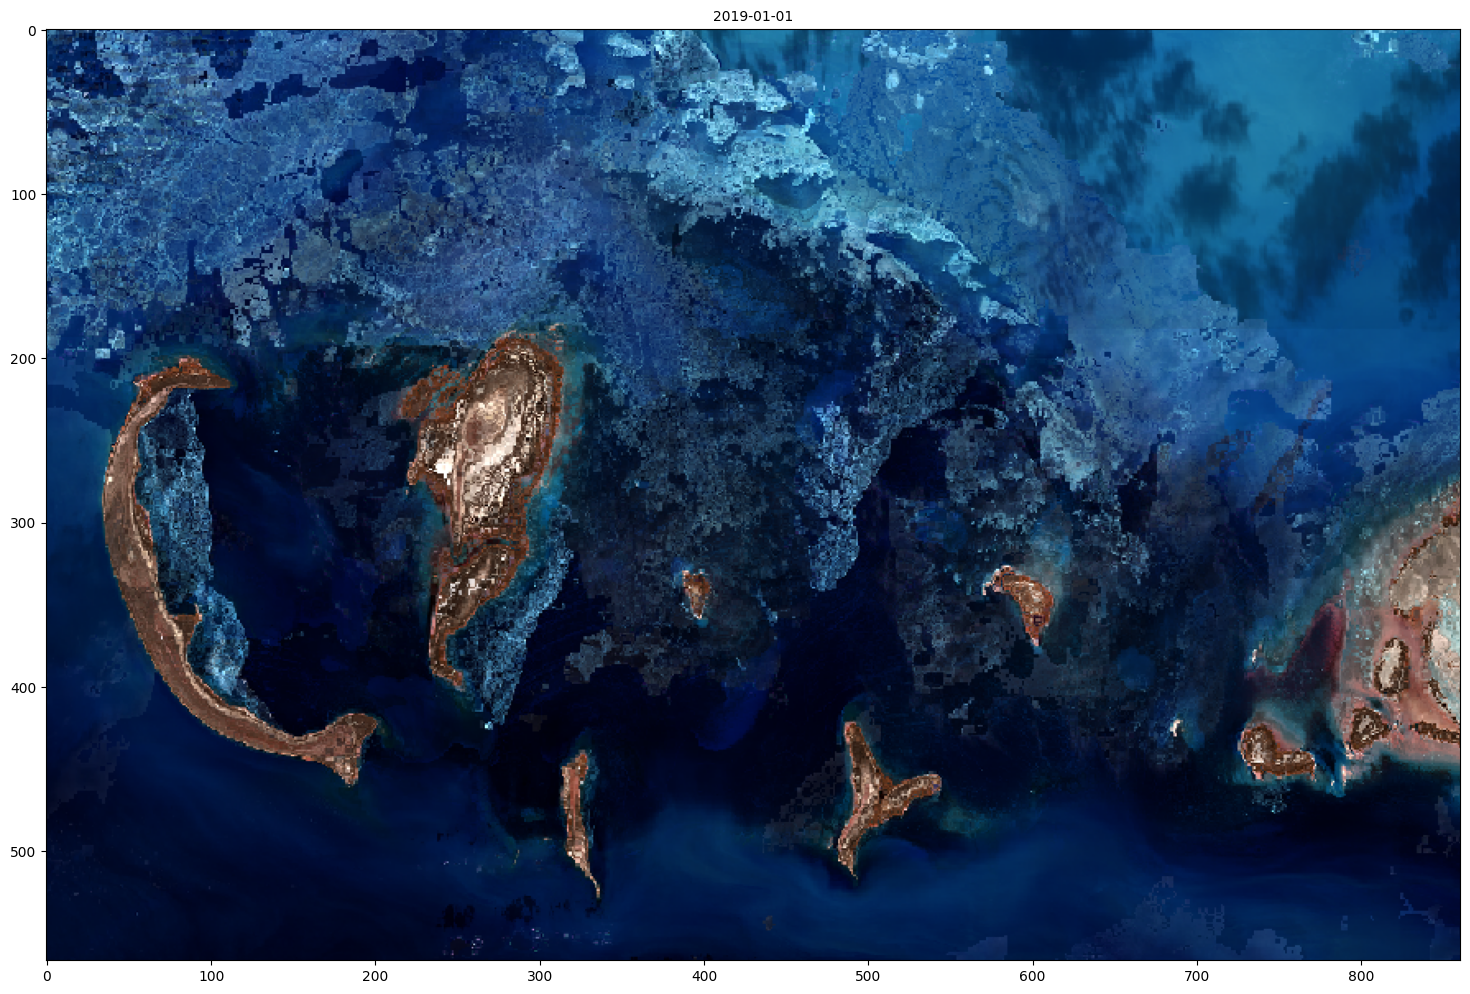

In [43]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.imshow(data)
ax.set_title(tile_time.date().isoformat(), fontsize=10)

plt.tight_layout()

## Configure collections
In the above case, bands are not defined before the tile ingestion process. BYOC service then automatically configures bands based on the first ingested tile and names the band after the filename unless a band placeholder is defined (see [creating a new tile](#Creating-a-new-tile-(and-ingesting-it-to-collection)) section). If the first ingested tile is a multi-band TIFF, the band index in 1-based numbering is also added at the end, e.g., the bands in a multi-band file named `RGB.tiff` would be named `RGB_1`, `RGB_2`, etc.

The automatic configuration generally configures all bands in a TIFF; however, BYOC service also allows user to configure bands manually. This can be useful when users have a multi-band TIFF but are only interested in ingesting part of the bands. Instead of trying to separate a multi-band TIFF into several single-band TIFFs, one can configure bands manually and ingest those specific bands only.

### Automatic band configuration

Let's create a new collection without bands configuration.

In [44]:
byoc_auto_config = ByocCollection(name="byoc-auto-config", s3_bucket="byoc-config-demo")
byoc_auto_config_collection = byoc.create_collection(byoc_auto_config)

At this step, there is no band configured and we can check the configuration status using the following code.

In [45]:
byoc_auto_config_collection = byoc.get_collection(byoc_auto_config_collection["id"])
byoc_auto_config_collection["isConfigured"]

False

Now let's try to ingest a true color TIFF which has red, green, and blue band.

In [46]:
example_tile = ByocTile(path="(BAND)_COG.tiff", sensing_time=dt.datetime(2022, 12, 1))
added_tile = byoc.create_tile(byoc_auto_config_collection, example_tile)

added_tile

{'id': '8640375e-f90b-464f-8540-bae32f07292e',
 'created': '2023-01-13T11:57:22.653128Z',
 'ingestionStart': '2023-01-13T11:57:22.653128Z',
 'sensingTime': '2022-12-01T00:00:00Z',
 'path': '(BAND)_COG.tiff',
 'status': 'WAITING'}

In [47]:
added_tile_info = byoc.get_tile(collection=byoc_auto_config_collection["id"], tile=added_tile["id"])
added_tile_info["status"]

'INGESTED'

After the tile being ingested successfully, we can see that the configuration status changes to True and the band information is stored in the `additionalData` dictionary.

In [50]:
byoc_auto_config_collection = byoc.get_collection(byoc_auto_config_collection["id"])
byoc_auto_config_collection["isConfigured"]

True

In [51]:
byoc_auto_config_collection["additionalData"]

{'bands': {'RGB_1': {'bitDepth': 8,
   'source': 'RGB',
   'bandIndex': 1,
   'sampleFormat': 'UINT'},
  'RGB_2': {'bitDepth': 8,
   'source': 'RGB',
   'bandIndex': 2,
   'sampleFormat': 'UINT'},
  'RGB_3': {'bitDepth': 8,
   'source': 'RGB',
   'bandIndex': 3,
   'sampleFormat': 'UINT'}},
 'maxMetersPerPixel': 37.221478429918854,
 'extent': {'type': 'Polygon',
  'coordinates': [[[12.44693, 41.870072],
    [12.44693, 41.917096],
    [12.541001, 41.917096],
    [12.541001, 41.870072],
    [12.44693, 41.870072]]]},
 'fromSensingTime': '2022-12-01T00:00:00Z',
 'toSensingTime': '2022-12-01T00:00:00Z',
 'hasSensingTimes': 'YES'}

### Manual band configuration

Now let's try to create a pre-configured BYOC collection. In this example, the red, green, and blue band all need to be configured so that the true color TIFF can be fully ingested.

In [52]:
band_config = ByocCollectionAdditionalData(
    bands={
        # source should be the string inside (BAND) placeholder
        "R": ByocCollectionBand(source="RGB", band_index=1, bit_depth=8, sample_format="UINT"),
        "G": ByocCollectionBand(source="RGB", band_index=2, bit_depth=8, sample_format="UINT"),
        "B": ByocCollectionBand(source="RGB", band_index=3, bit_depth=8, sample_format="UINT"),
    }
)
byoc_manual_config = ByocCollection(
    name="byoc-manual-config", s3_bucket="byoc-config-demo", additional_data=band_config
)

byoc_manual_config_collection = byoc.create_collection(byoc_manual_config)

By checking the configuration status and additional data, we can see that the data collection is configured and the band information is stored in the `additionalData` dictionary before any tiles being ingested. 

In [53]:
byoc_manual_config_collection["isConfigured"]

True

In [54]:
byoc_manual_config_collection["additionalData"]

{'bands': {'R': {'bitDepth': 8,
   'source': 'RGB',
   'bandIndex': 1,
   'sampleFormat': 'UINT'},
  'G': {'bitDepth': 8,
   'source': 'RGB',
   'bandIndex': 2,
   'sampleFormat': 'UINT'},
  'B': {'bitDepth': 8,
   'source': 'RGB',
   'bandIndex': 3,
   'sampleFormat': 'UINT'}}}

Then, we can ingest tiles as shown above.

In [55]:
added_tile = byoc.create_tile(byoc_manual_config_collection, example_tile)
added_tile

{'id': '148bb8dd-2465-4b99-a29c-042b36f28281',
 'created': '2023-01-13T12:43:43.903814Z',
 'ingestionStart': '2023-01-13T12:43:43.903814Z',
 'sensingTime': '2022-12-01T00:00:00Z',
 'path': '(BAND)_COG.tiff',
 'status': 'WAITING'}

In [56]:
added_tile_info = byoc.get_tile(collection=byoc_manual_config_collection["id"], tile=added_tile["id"])
added_tile_info["status"]

'INGESTED'

### Ingest a specific band of the TIFF

One can also ingest a specific band from a multi-band TIFF. In this example, we will demonstrate how to only ingest green band from a true color TIFF.

Let's start from creating a BYOC collection with green band being configured only.

In [57]:
specific_band_config = ByocCollectionAdditionalData(
    bands={
        # here we specify the second band which is the green band to be ingested
        "G": ByocCollectionBand(source="RGB", band_index=2, bit_depth=8, sample_format="UINT")
    }
)
byoc_demo_manual_specific_band = ByocCollection(
    name="byoc-specific-band-config", s3_bucket="byoc-config-demo", additional_data=specific_band_config
)

byoc_specific_band_config_collection = byoc.create_collection(byoc_demo_manual_specific_band)

This time we can see that the collection is configured and there is only one band in the additional data dictionary, meaning that BYOC service will only ingest the specified band that is pre-defined for the collection from the example multi-band TIFF.

In [58]:
byoc_specific_band_config_collection["isConfigured"]

True

In [59]:
byoc_specific_band_config_collection["additionalData"]

{'bands': {'G': {'bitDepth': 8,
   'source': 'RGB',
   'bandIndex': 2,
   'sampleFormat': 'UINT'}}}

We can now use the same code to ingest the tile to the collection, but only the configured band will be ingested by the BYOC service. 

In [60]:
added_tile = byoc.create_tile(byoc_specific_band_config_collection, example_tile)
added_tile

{'id': '9cb31763-9a81-420e-aff0-ed8aa6728412',
 'created': '2023-01-13T12:44:28.470325Z',
 'ingestionStart': '2023-01-13T12:44:28.470325Z',
 'sensingTime': '2022-12-01T00:00:00Z',
 'path': '(BAND)_COG.tiff',
 'status': 'WAITING'}

In [61]:
added_tile_info = byoc.get_tile(collection=byoc_specific_band_config_collection["id"], tile=added_tile["id"])
added_tile_info["status"]

'INGESTED'